In [1]:
dataset_name = "loris3/stratified_10m_curriculum"
curriculum_name ="lognorm.pt"


In [2]:
import plotting

In [3]:
df, curriculum = plotting.load_data_for_plotting(dataset_name, curriculum_name)

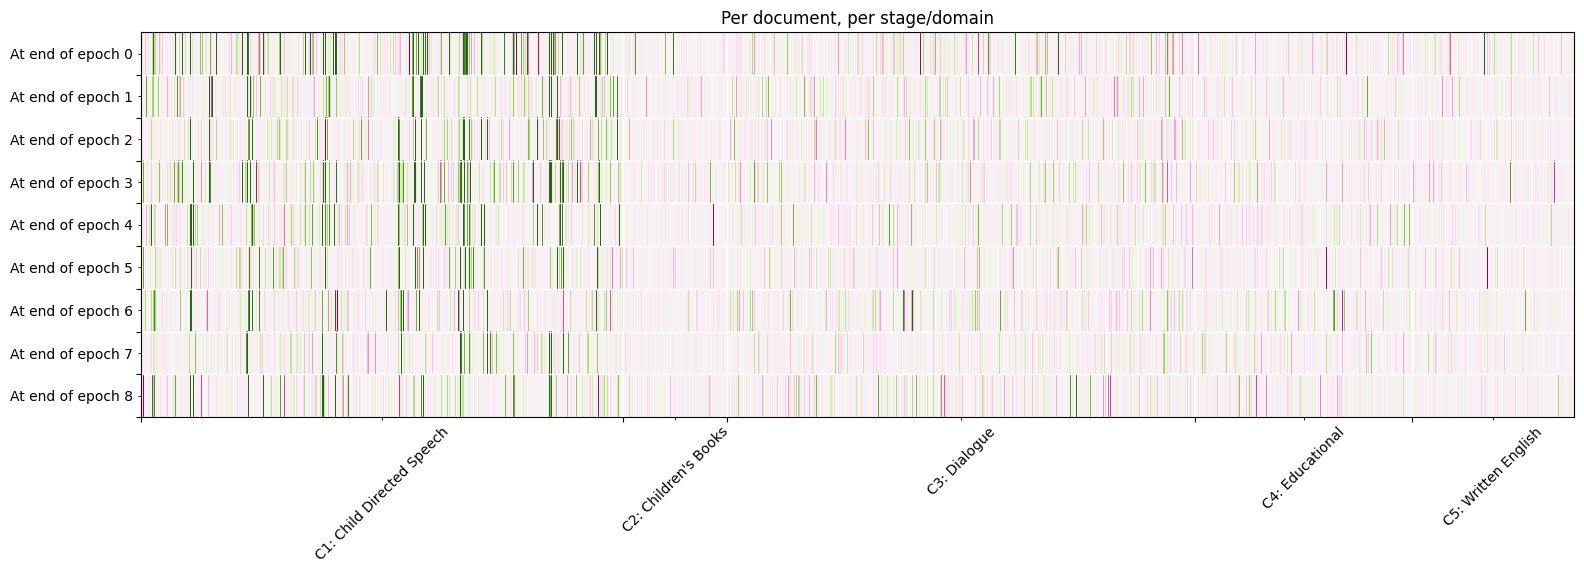

In [4]:
plotting.plot_per_document_per_stage(df)

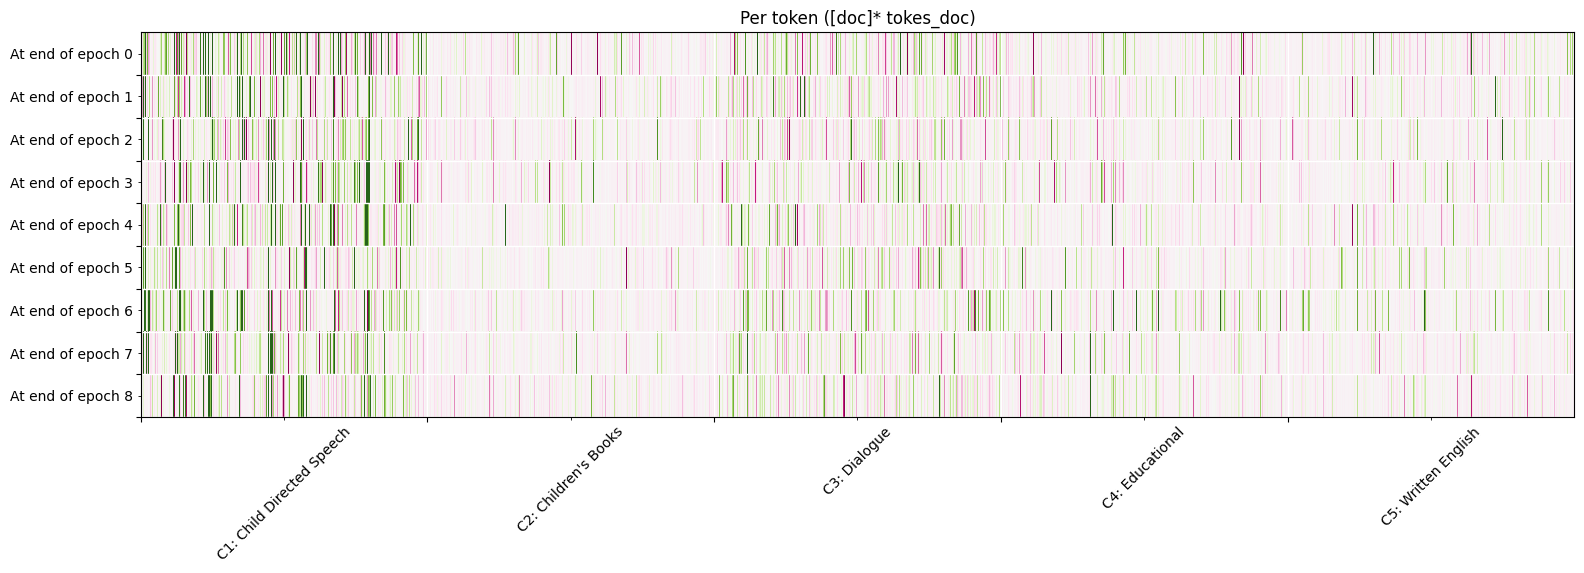

In [5]:
plotting.plot_per_token_per_stage(df)

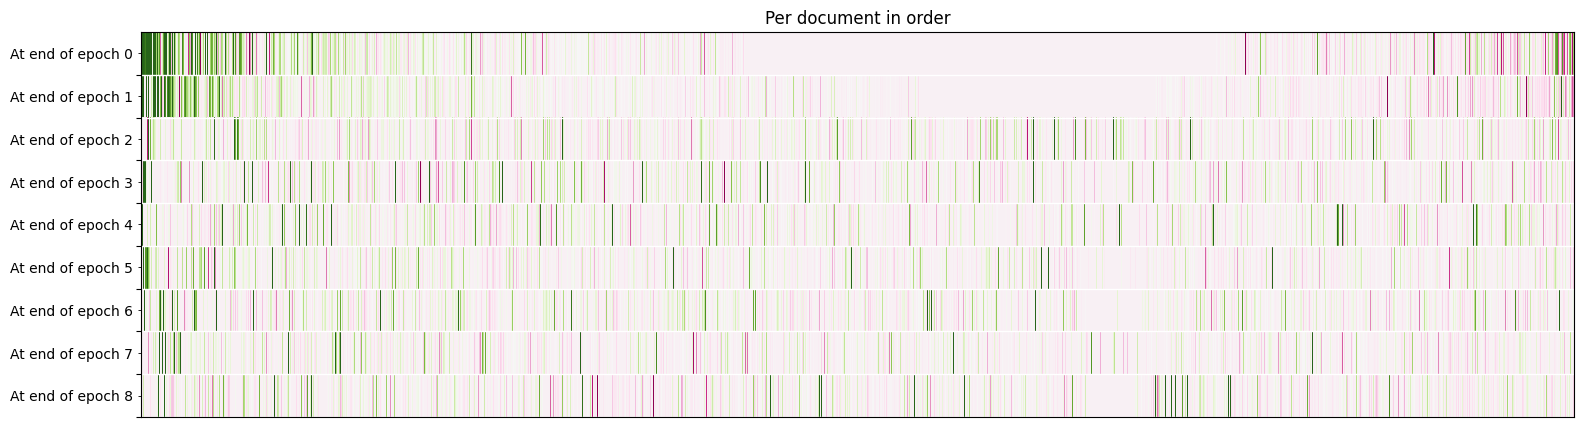

In [6]:
plotting.plot_per_document_in_order(df, curriculum)

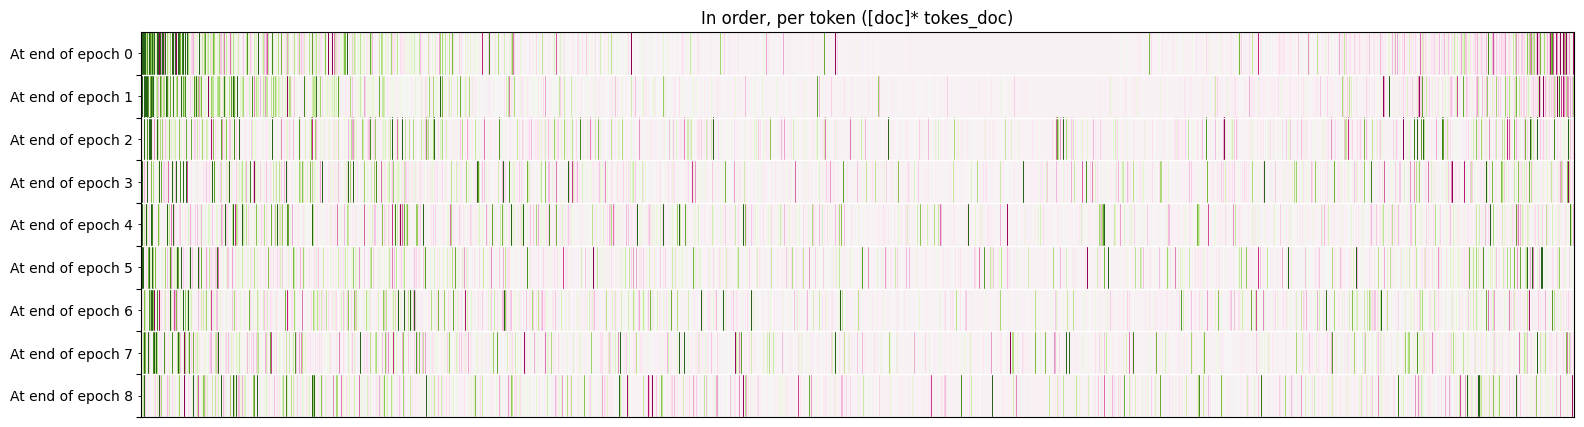

In [7]:
plotting.plot_per_token_in_order(df,curriculum)

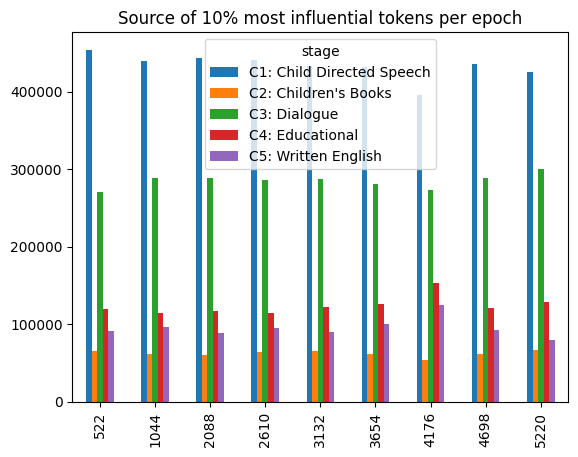

Text(0.5, 1.0, 'Source of 10% least influential tokens per epoch')

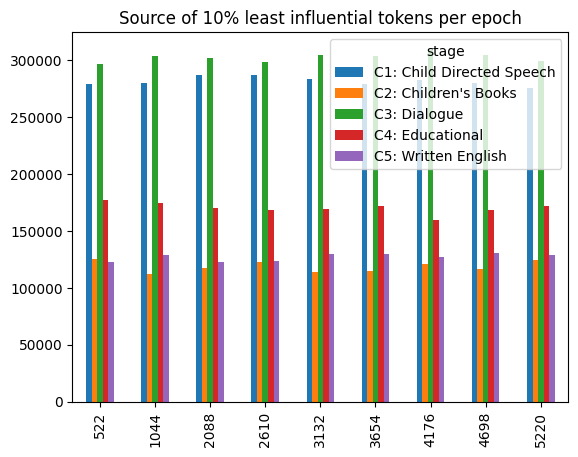

In [8]:
import pandas as pd
from matplotlib import pyplot as plt

pd.concat([pd.concat([df[col].repeat(df["document_lenght"]), df["stage"].repeat(df["document_lenght"])],axis=1).sort_values(by=col,ascending=False).head(int(df["document_lenght"].sum()*0.1)).groupby("stage").count() for col in df.columns[0:-5]],axis=1).T.plot.bar()
plt.title("Source of 10% most influential tokens per epoch")
plt.show()
pd.concat([pd.concat([df[col].repeat(df["document_lenght"]), df["stage"].repeat(df["document_lenght"])],axis=1).sort_values(by=col,ascending=False).tail(int(df["document_lenght"].sum()*0.1)).groupby("stage").count() for col in df.columns[0:-5]],axis=1).T.plot.bar()
plt.title("Source of 10% least influential tokens per epoch")

<Axes: >

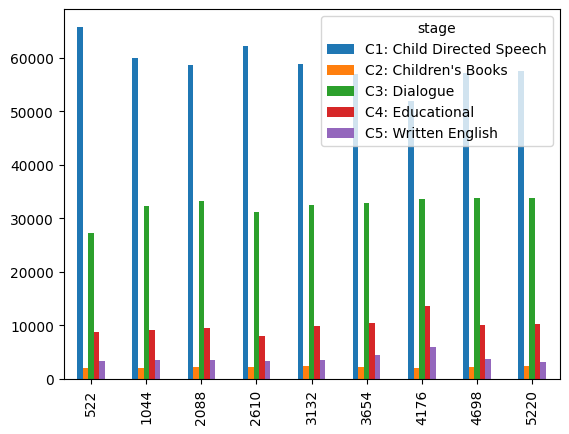

In [9]:
import pandas as pd
pd.concat([df[[col,"stage"]].sort_values(by=col,ascending=False).head(int(len(df)*0.1)).groupby("stage").count() for col in df.columns[0:-5]],axis=1).T.plot.bar()

In [10]:
dfb = df[["total","document_lenght","stage"]].sort_values(by="total",ascending=False).head(int(len(df)*0.1))

In [11]:
dfb = df[["total","document_lenght","stage"]].sort_values(by="total",ascending=False).head(int(len(df)*0.1))

<Axes: xlabel='document_lenght', ylabel='Count'>

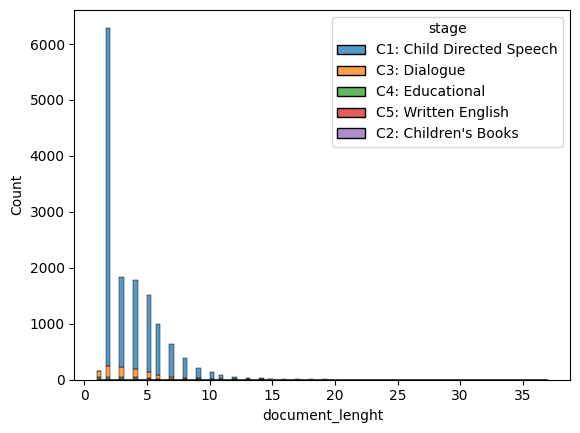

In [12]:
import seaborn as sns
sns.histplot(dfb, x="document_lenght", bins=100, weights=dfb["total"], hue="stage",multiple="stack")


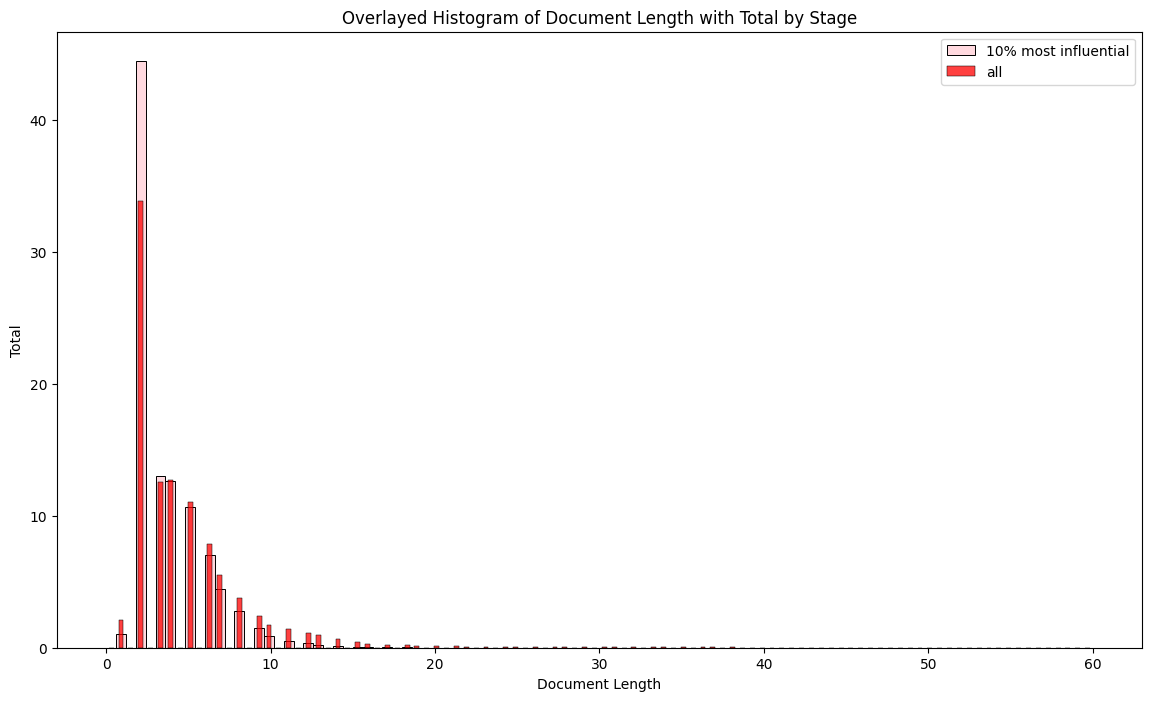

In [13]:

plt.figure(figsize=(14, 8))

# Plot the first histogram

sns.histplot(data=dfb, label="10% most influential",x="document_lenght", bins=100, weights=dfb["total"], multiple="stack", color="pink",alpha=0.6, stat="percent",binrange=(0,60))
sns.histplot(data=df, label="all", x="document_lenght", bins=100, weights=df["total"],  multiple="stack",shrink=0.5,color="red", stat="percent",binrange=(0,60))

# Plot the second histogram with a different visual style

plt.title('Overlayed Histogram of Document Length with Total by Stage')
plt.xlabel('Document Length')
plt.ylabel('Total')
plt.legend()

plt.show()

In [14]:
df.groupby("stage")["document_lenght"].describe()

,count,mean,std,min,25%,50%,75%,max
stage,,,,,,,,
C1: Child Directed Speech,360533.0,5.547340,3.505760,2.0,3.0,5.0,7.0,67.0
C2: Children's Books,77384.0,25.845071,28.687602,0.0,10.0,18.0,32.0,1055.0
C3: Dialogue,349650.0,5.719969,4.643856,0.0,3.0,5.0,7.0,177.0
C4: Educational,161554.0,12.379755,23.679999,0.0,4.0,7.0,15.0,5104.0
C5: Written English,121200.0,16.501196,28.066462,0.0,3.0,11.0,14.0,627.0


In [ ]:
zgotrefoül+ö

In [ ]:
import pandas as pd
pd.concat([df[[col,"document_lenght"]].sort_values(by=col,ascending=False).head(int(len(df)*0.1)) for col in df.columns[0:-5]],axis=1).T.plot.bar()

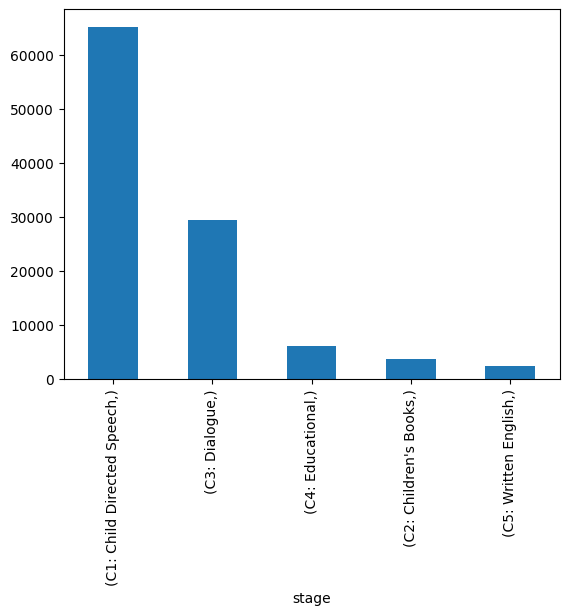

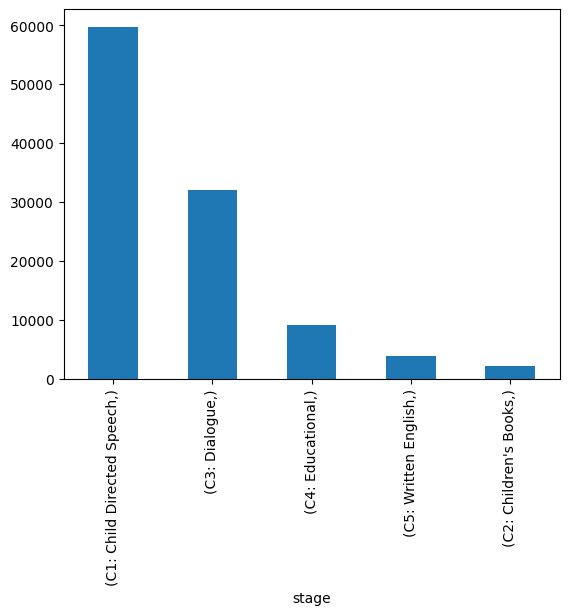

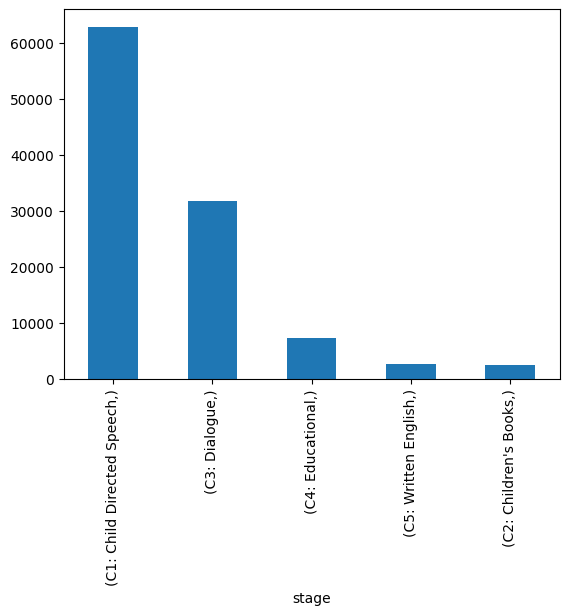

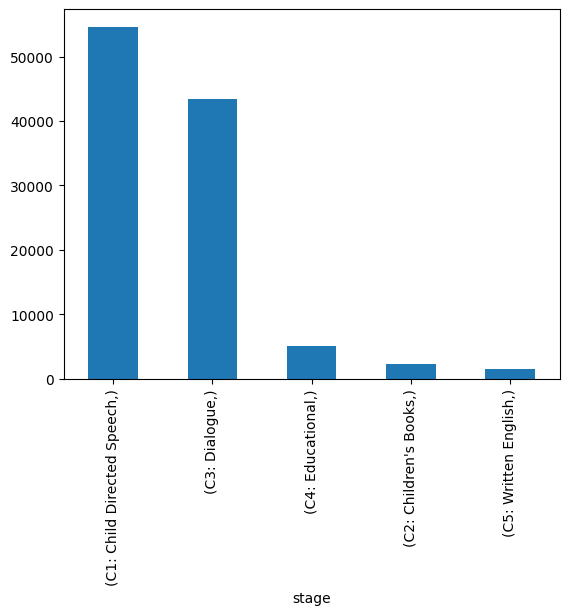

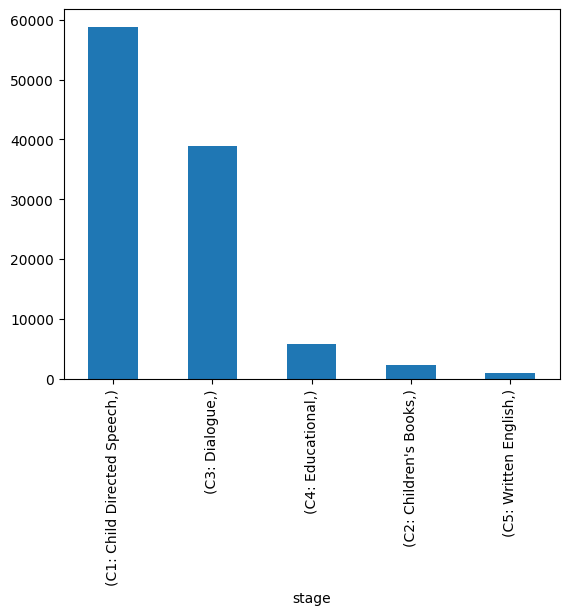

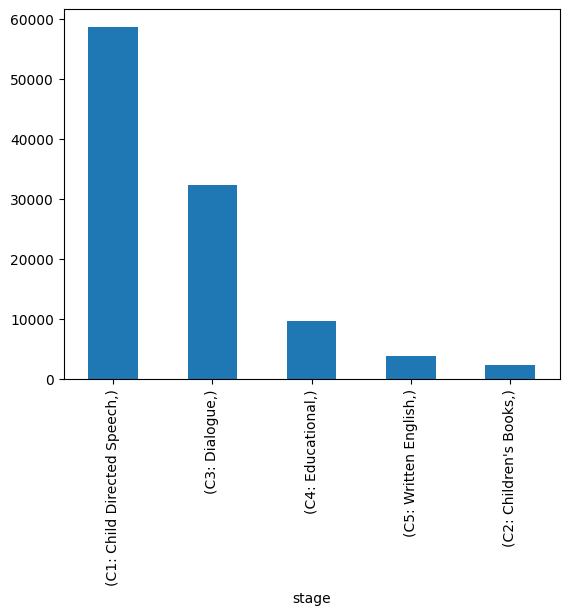

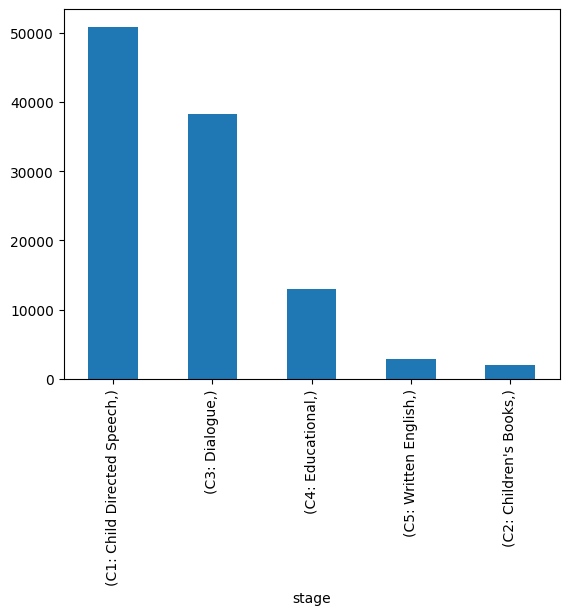

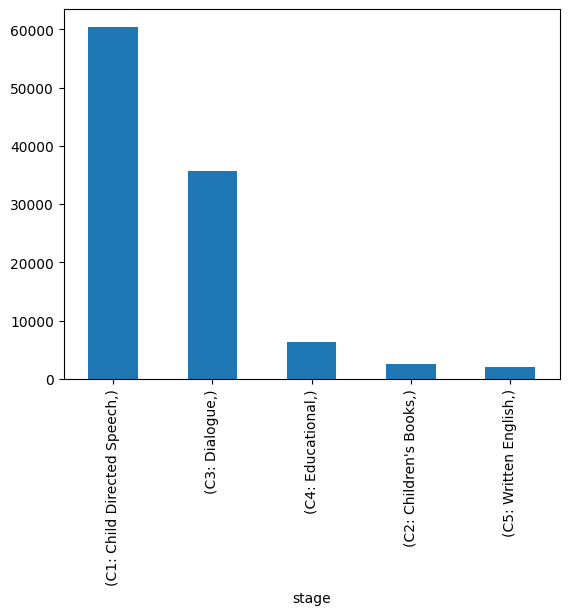

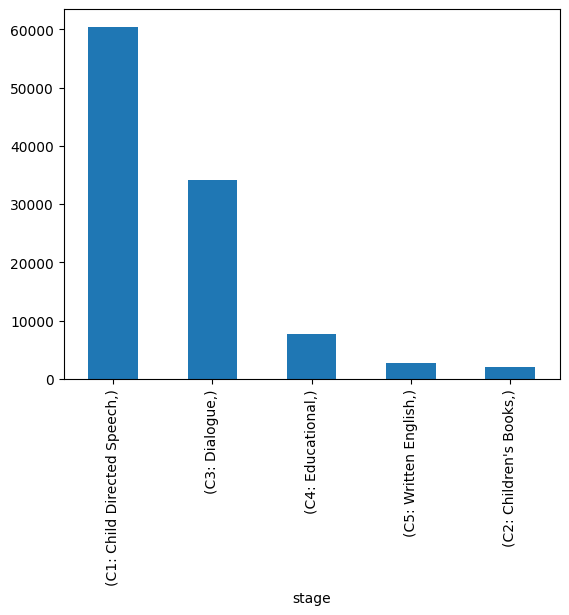

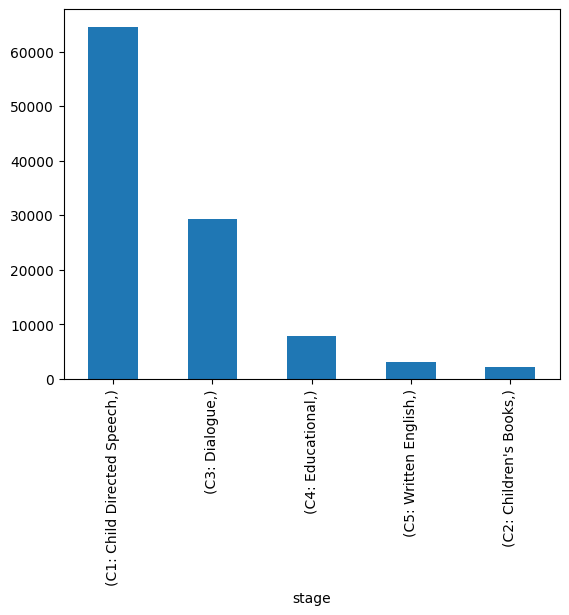

In [ ]:
from matplotlib import pyplot as plt


for col in df.columns[0:-5]:
    df[[col,"stage"]].sort_values(by=col,ascending=False).head(int(len(df)*0.1)).value_counts(subset=["stage"]).plot.bar()
    plt.show()

In [ ]:
df["stage"].unique()

array(['C1: Child Directed Speech', "C2: Children's Books",
       'C3: Dialogue', 'C4: Educational', 'C5: Written English'],
      dtype=object)